# Installation
The purpose of this notebook is to give a working example of the library and how to use it. First, we begin by installing the library. Note that it takes some time to install the library because of the dependencies, be patient!

In [1]:
%pip install git+https://github.com/JadM133/RRAEs.git@VAE_fix_CNN

  Cloning https://github.com/JadM133/RRAEs.git (to revision VAE_fix_CNN) to c:\users\jadmo\appdata\local\temp\pip-req-build-f3fhxbsi
  Resolved https://github.com/JadM133/RRAEs.git to commit 56f2556487ea82320945ba3dcd733d617ee286dd
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/JadM133/RRAEs.git 'C:\Users\jadmo\AppData\Local\Temp\pip-req-build-f3fhxbsi'
  Running command git checkout -b VAE_fix_CNN --track origin/VAE_fix_CNN
  branch 'VAE_fix_CNN' set up to track 'origin/VAE_fix_CNN'.
  Switched to a new branch 'VAE_fix_CNN'


Now that the library is installed, you can acces the library with the name ``RRAEs``. We begin by creating a simple training data, the library presents a function within ``utilities`` named ``get_data`` that generates the data used in the paper and many more. In this case, we will use the shifted sine functions as a simple example.

Train shape: (200, 17), or (200, 17)
Test shape: (200, 80), or (200, 80)
Train parameters shape: (17, 1)
Test parameters shape: (80, 1)


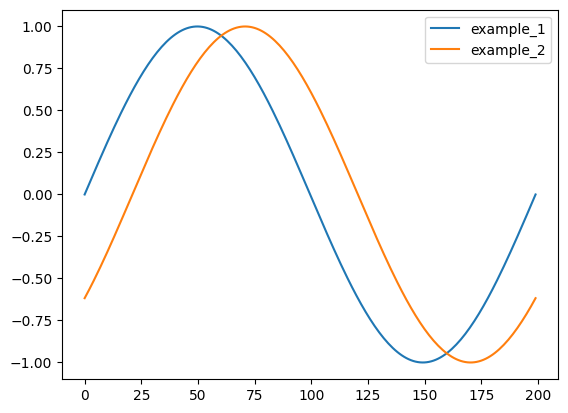

In [2]:
from RRAEs.utilities import get_data
import matplotlib.pyplot as plt
import jax.numpy as jnp
x_train, x_test, p_train, p_test, y_train, y_test, _ = get_data("shift")
# In general, you won't use get_data, you will have your own data with the same shapes.
print(f"Train shape: {x_train.shape}, or {y_train.shape}")
print(f"Test shape: {x_test.shape}, or {y_test.shape}")
print(f"Train parameters shape: {p_train.shape}")
print(f"Test parameters shape: {p_test.shape}")
plt.plot(x_train[:, 0], label="example_1")
plt.plot(x_train[:, 2], label="example_2")
plt.legend()

In this case, ``x_train`` and ``y_train`` are the same matrices, since we want the autoencoder to have as an output the same thing as the input. Similarly, ``x_test`` and ``y_test`` are the same. We can also see that we only have one parameter (the last dimension of ``p_train`` and ``p_test``), which is expected for the problem of the shifted sines (shifted by one parameter). In general, when generating your own data, x and y should have the shape (T x N) and the parameters should have a shape of (N x P), N being the number of samples (wether for train or test), T being the time discretisation dimension, and P being the dimension of the parametric space.

Next, we creat the model,

In [3]:
from RRAEs import Strong_RRAE_MLP, Weak_RRAE_MLP
import jax.random as jrandom
latent_size = 520
k_max = 1
kwargs_enc={"width_size":64, "depth":1}
kwargs_dec={"width_size":64, "depth":5}
model_key = jrandom.PRNGKey(0) # JAX needs key for generating random values, this is a necessary keword argument in the classes.

model_Strong = Strong_RRAE_MLP(x_train.shape[0], latent_size, k_max, key=model_key, kwargs_enc=kwargs_enc, kwargs_dec=kwargs_dec)
model_Weak = Weak_RRAE_MLP(x_train.shape[0], latent_size, k_max, x_train.shape[-1], key=model_key, kwargs_enc=kwargs_enc, kwargs_dec=kwargs_dec)

# You can give any kwargs needed for the encoder in kwargs_enc, and for the decoder in kwargs_dec. If nothing is given,
# the encoder will have a depth of 1 and a width of 64, and the decoder will have a depth of 6 and a width of 64.

Let's test the models now by aplying them to our training data.

In [4]:
print(f"x_train shape before: {x_train.shape}")
print(f" Shape after Strong: {model_Strong(x_train).shape}")
print(f" Shape after Weak: {model_Weak(x_train).shape}")

x_train shape before: (200, 17)
 Shape after Strong: (200, 17)
 Shape after Weak: (200, 17)


We expect all shapes to be the same since we want to predict the original values as output, great!

The Strong formulation performs a truncates SVD after the latent space, while the weak one for now is just a Vanilla Autoencoder, the difference will come in the loss later on.

Now, let's train the model on our data. The library provides a trainor class that does the training for you, if you know how to use it :) 

We define the trainor class for each of the Weak/Strong formulation as follows (In practice, you only need one of these).

In [5]:
from RRAEs import Trainor_class

model_cls = Strong_RRAE_MLP # Without parenthesis! Only the class

trainor_Strong = Trainor_class(
            x_train,
            model_cls,
            in_size=x_train.shape[0],
            latent_size=latent_size,  # 4600
            k_max=k_max,
            norm_in="minmax", # could choose "meanstd", or "None"
            norm_out="minmax", # could choose "meanstd", or "None"
            out_train=x_train,
            folder=f"test/", # folder to save later
            file=f"testing_strong", # file in folder to save later
            key=jrandom.PRNGKey(0),
        )

model_cls = Weak_RRAE_MLP # Without parenthesis! Only the class
trainor_Weak = Trainor_class(
            x_train,
            model_cls,
            latent_size=latent_size,  # 4600
            in_size=x_train.shape[0],
            data_size=x_train.shape[-1], # Only needed for Weak_RRAE_MLP
            k_max=k_max,
            folder=f"test/",
            file=f"testing_Weak",
            norm_in="minmax", # could choose "meanstd", or "None"
            norm_out="minmax", # could choose "meanstd", or "None"
            out_train=x_train,
            key=jrandom.PRNGKey(100),
        )

Now, we can use the ``fit`` method of the trainor class, and give it any training arguments as follows,

In [6]:
training_kwargs = {
            "step_st": [1500], # number of batches strategy
            "batch_size_st": [20, 20, 20], # batch size strategy
            "lr_st": [1e-3, 1e-4], # learning rate strategy
            "print_every": 100,
        }

_ = trainor_Strong.fit(
    x_train,
    y_train,
    loss_func="Strong",
    training_key=jrandom.PRNGKey(50),
    **training_kwargs,
)

Training the RRAE...
Step: 0, Loss: 99.69287872314453, Computation time: 0.7693630999419838
Step: 100, Loss: 57.13981246948242, Computation time: 0.49233580101281404
Step: 200, Loss: 41.78825378417969, Computation time: 0.5474080999847502
Step: 300, Loss: 40.3974723815918, Computation time: 0.4521143976598978
Step: 400, Loss: 11.209572792053223, Computation time: 0.5320512007456273
Step: 500, Loss: 6.429886817932129, Computation time: 0.5318263017106801
Step: 600, Loss: 4.363488674163818, Computation time: 0.48072760039940476
Step: 700, Loss: 3.8151535987854004, Computation time: 0.4659131998196244
Step: 800, Loss: 3.461122989654541, Computation time: 0.5045091977808625
Step: 900, Loss: 3.3449344635009766, Computation time: 0.49449010333046317
Step: 1000, Loss: 5.9743428230285645, Computation time: 0.5104497002903372
Step: 1100, Loss: 4.691559314727783, Computation time: 0.5142124004196376
Step: 1200, Loss: 3.647223472595215, Computation time: 0.4980284010525793
Step: 1300, Loss: 1.781

We trained RRAEs with the Strong formulation!!! Training using the Weak formulation is Similar, by replacing ``loss_func`` by ``Weak`` the loss automatically includes matrices ``U`` and ``A`` in the loss (check the paper for more details). The only difference is that we might multiply the learning rate before modifying the gradient of ``A`` (check Appendix B in the paper for why and how this helps, instead of modifying the loss constants). This is done as follows,

In [7]:
# training_kwargs = {
#             "step_st": [1500, 1500], # number of batches strategy
#             "batch_size_st": [20, 20, 20], # batch size strategy
#             "lr_st": [1e-3, 1e-4], # learning rate strategy
#             "print_every": 100,
#             # For now, the next two lines have some unfixed bugs...
#             # "mul_lr":[0.05, 0.05, 0.05], # The values of kappa (to multiply lr for A)
#             # "mul_lr_func": lambda tree: (tree.v_vt.vt,), # Who will be affected by kappa, this means A
#         }
# _ = trainor_Weak.fit(
#     x_train,
#     y_train,
#     loss_func="Weak",
#     training_key=jrandom.PRNGKey(50),
#     **training_kwargs,
# )

As you can see, choosing the Weak option for the loss function will automatically print loss1 and loss2, the first being how far our prediction of the input is, and loss2 give us an idea of how low the rank is. If loss2 is decreasing too fast, you should decrease the value of kappa (i.e. mul_lr), otherwise, you must increase it.

Now, after training, we assign most of the important results inside the trainor class (i.e. ``trainor_Strong`` or ``trainor_Weak``). Next, we show how to interpolate in the latent space for the test set. The trainor class offers a function ``post_process`` that does that automatically as follows.

In [8]:
error_train_str, error_test_str, _, _ = trainor_Strong.post_process(x_train, y_train, x_test, y_test)
# error_train_we, error_test_we, _, _ = trainor_Weak.post_process(x_train, y_train)

Train error on original output:  2.7429767
Train error on normalized output:  1.5840865
Test error on original output:  10.304211
Test error on normalized output:  5.9493804
Total training time:  8.271187007660046


You can also find interpolated values of parameters in the latent space and decode it by using the following function

In [9]:
_ = trainor_Strong.AE_interpolate(p_train, p_test, y_test)

Test (interpolation) error over original output:  3.5623019
Test (interpolation) error over normalized output:  2.0567794


Now, all the important variables are saved inside the trainor class, you can access some stuff as follows,

In [10]:
trainor_Strong.model # the model trained
trainor_Strong.y_pred_test # predictions when passing test set through RRAE
trainor_Strong.y_pred_train # predictions over train
trainor_Strong.y_pred_train_o # predictions over original train data (remove output norm)
trainor_Strong.y_pred_test_o # predictions over original test data (remove output norm)
trainor_Strong.y_pred_interp_test # prediction over test bet weh interpolated in the latent space using p_test and p_train (normalized)
trainor_Strong.y_pred_interp_test_o # same as above but original

Array([[-0.99218845,  0.67817926, -0.33794057, ...,  1.0138352 ,
         0.7433711 , -0.8618073 ],
       [-0.9913765 ,  0.6660894 , -0.31099808, ...,  0.9947536 ,
         0.72714627, -0.86959225],
       [-0.9974634 ,  0.6319729 , -0.27996153, ...,  1.0052178 ,
         0.70184314, -0.88564646],
       ...,
       [-0.984066  ,  0.7342881 , -0.3946013 , ...,  0.9957706 ,
         0.7876766 , -0.8192872 ],
       [-0.9896233 ,  0.7089213 , -0.36971396, ...,  0.9972626 ,
         0.76578116, -0.84364164],
       [-0.9934461 ,  0.6946819 , -0.3400259 , ...,  1.0017259 ,
         0.7552664 , -0.8518015 ]], dtype=float32)

You can also find the latent space SVD coefficients by performing the following:

In [11]:
basis, coeffs, sigs = trainor_Strong.model.latent(x_train, ret=True)
#Note: Coeffs already include sigs, but sigs are returne anyway if needed.
print(f"basis shape: {basis.shape}")
print(f"coeffs shape: {coeffs.shape}")

coeffs = trainor_Weak.model.v_vt.vt
basis = trainor_Weak.model.v_vt.v
print(f"basis shape: {basis.shape}")
print(f"coeffs shape: {coeffs.shape}")

basis shape: (520, 1)
coeffs shape: (1, 17)
basis shape: (520, 1)
coeffs shape: (1, 17)


The autoencoder model also allows you to perform seperate operations (e.g. encoe and decode), normalization is done automatically.

In [12]:
encoded = trainor_Strong.model.encode(x_train)
latent = trainor_Strong.model.latent(x_train)
decoded = trainor_Strong.model.decode(latent)
print(jnp.linalg.norm(x_train - decoded)/jnp.linalg.norm(x_train)*100)

2.743033


And many more! For example, let's plot some predictions over the test set to compare between the Weak and Strong formulation.

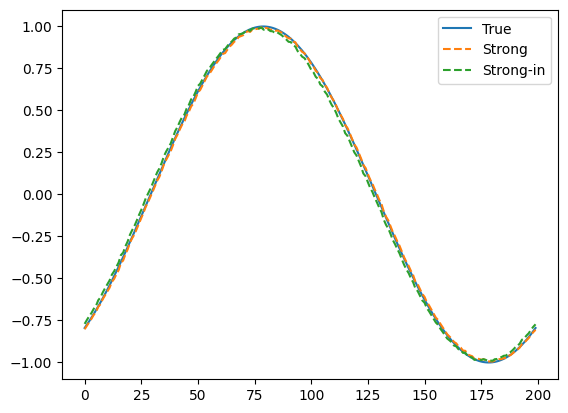

In [13]:
idx = 15
plt.plot(y_test[:, idx], label="True")
plt.plot(trainor_Strong.y_pred_interp_test_o[:, idx], label="Strong", linestyle="--")
plt.plot(trainor_Strong.y_pred_test_o[:, idx], label="Strong-in", linestyle="--")
# plt.plot(trainor_Weak.y_pred_test[:, 10], label="Weak", linestyle="--")
plt.legend()

Now definitely, the Weak method can do as well as the Strong one for the right value of kappa, you just need some fine tuning.

Finally, you can save the model by using the built-in ``save`` function of the trainor class, it will save the model in the foler and file that you specified previously when defining the trainor class as follows.

In [14]:
trainor_Strong.save(coeffs=coeffs, basis=basis) # you could save any other parameter by passing it as a keyword argument
trainor_Weak.save(coeffs=coeffs, basis=basis)

Model saved in test/testing_strong.pkl
Model saved in test/testing_Weak.pkl


Later on, if you want to load the trainor again, you define a trainor class with no attributes and load the class as follows

In [15]:
import os
folder = f"test/"
file = f"testing_weak"
new_trainor = Trainor_class()
new_trainor.load(os.path.join(folder, file))